In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2022-11-08 14:19:38.696233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 14:19:39.061750: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 14:19:40.064699: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-08 14:19:40.064857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
n_channels = 16
alpha = 0.1

In [43]:
def load_image(filename):
    img = tf.keras.preprocessing.image.load_img(path=filename, color_mode='rgba', target_size=(64, 64))
    img = np.array(img) / 255.0

    # add transparency channel for black pixels
    img[img[:,:,2] < 0.1] = 0
    # add red border around the image
    img[0, :, 0] = 1
    img[-1, :, 0] = 1
    img[:, 0, 0] = 1
    img[:, -1, 0] = 1
    
    chars = np.zeros((64, 64, 12), dtype=np.float32)
    img = np.append(img, chars, axis=2)
    img = tf.expand_dims(img, 0)
    return img

def rgba(x):
    return x[0, :, :, :4]

def rgb(x):
  rgb, a = x[0, :, :, :3], tf.clip_by_value(x[0, :, :, 3:4], 0.0, 1.0)
  return 1.0-a+rgb

def plot(x):
    plt.imshow(rgb(x))
    plt.show()

def save_plot(x, filename):
    plt.imshow(rgb(x))
    plt.savefig('.\Imgs\Epoch ' + str(filename) + '.png')

def get_living_mask(x):
    channel_alpha = x[:, :, :, 3:4]
    return tf.nn.max_pool2d(channel_alpha, 3, [1, 1, 1, 1], 'SAME') > alpha

In [4]:
class NNA(tf.keras.Model):

    def __init__(self, n_channels):
        super().__init__()
        self.channel_n = n_channels
        self.alpha = alpha

        self.dmodel = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 1, activation=tf.nn.relu),
            tf.keras.layers.Conv2D(self.channel_n, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        self(tf.zeros([1, 3, 3, n_channels]))

    def perceive(self, x):
        cellID = tf.constant([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]], dtype=tf.float32)
        sobelX = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
        sobelY = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)

        kernel = tf.stack([cellID, sobelX, sobelY], -1)[:, :, None, :]
        kernel = tf.repeat(kernel, self.channel_n, 2)

        y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
        return y

    def call(self, x, steps = 1):
        pre_live_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y) * steps

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= 0.5
        x += dx * tf.cast(update_mask, tf.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_live_mask & post_life_mask
        return x * tf.cast(life_mask, tf.float32)

In [5]:
model = NNA(n_channels)

2022-11-08 14:20:01.967127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 14:20:02.011380: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-08 14:20:02.011401: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-08 14:20:02.011787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [6]:
lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([5000], [lr, lr*0.05])
optimizer = tf.keras.optimizers.Adam(lr_sched)
loss_object = tf.keras.losses.MeanSquaredError()

In [45]:
anim = []
anim_len = 500

for i in range(anim_len):
    anim.append(load_image('../data/export/frame_' + f'{i:05d}' + '.png'))

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


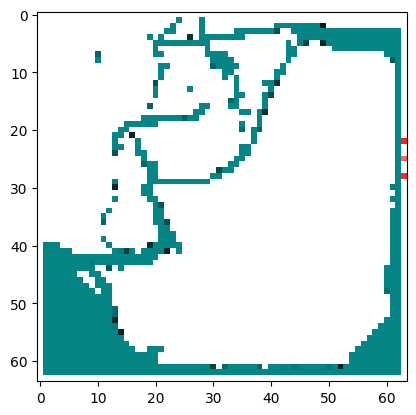

In [46]:
plot(anim[int(anim_len*0.2)])
plot(anim[int(anim_len*0.4)])
plot(anim[int(anim_len*0.6)])

In [10]:
def loss_f(x):
    return loss_object(rgba(IMG), rgba(x))

def train_step(x):
    n = tf.random.uniform([],64,96,tf.int32)
    with tf.GradientTape() as g:
        for i in tf.range(n):
            x = model(x)
        loss = loss_f(x) * 100
    gradients = g.gradient(loss, model.weights)
    gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.weights))
    return x, loss

In [11]:
def init_image():
    img = np.zeros((64, 64 , 4), dtype=np.float32)
    chars = np.zeros((64, 64, 12), dtype=np.float32)
    img = np.append(img, chars, axis=2)
    img[32,32,3:] = 1
    img = tf.expand_dims(img, 0)
    return img

In [12]:
x0 = init_image()

Epoch 1, Loss: 84.92668914794922


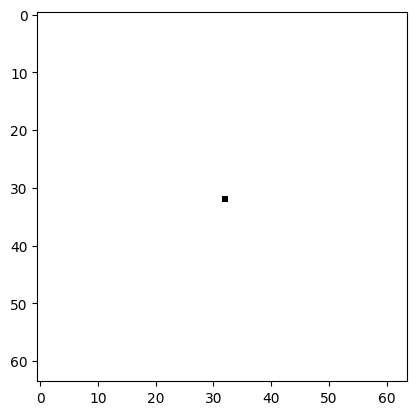

Epoch 2, Loss: 100.41767120361328
Epoch 3, Loss: 148.1219482421875
Epoch 4, Loss: 82.43081665039062
Epoch 5, Loss: 79.2124252319336
Epoch 6, Loss: 75.77169799804688
Epoch 7, Loss: 76.45635986328125
Epoch 8, Loss: 72.5228042602539
Epoch 9, Loss: 69.80082702636719
Epoch 10, Loss: 72.5281753540039
Epoch 11, Loss: 67.13212585449219
Epoch 12, Loss: 68.13761901855469
Epoch 13, Loss: 52.305458068847656
Epoch 14, Loss: 61.323814392089844
Epoch 15, Loss: 51.3664665222168
Epoch 16, Loss: 63.381256103515625
Epoch 17, Loss: 82.62882995605469
Epoch 18, Loss: 53.768272399902344
Epoch 19, Loss: 58.10725021362305
Epoch 20, Loss: 46.80363082885742
Epoch 21, Loss: 56.27909851074219
Epoch 22, Loss: 110.83746337890625
Epoch 23, Loss: 85.79753875732422
Epoch 24, Loss: 39.173805236816406
Epoch 25, Loss: 50.85841369628906


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 26, Loss: 36.349544525146484


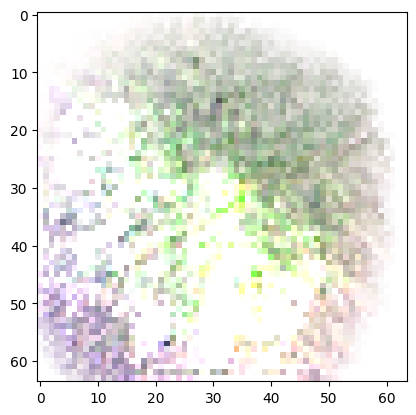

Epoch 27, Loss: 44.27134323120117
Epoch 28, Loss: 35.70431900024414
Epoch 29, Loss: 99.79224395751953
Epoch 30, Loss: 54.93433380126953
Epoch 31, Loss: 44.54589080810547
Epoch 32, Loss: 36.56482696533203
Epoch 33, Loss: 66.00264739990234
Epoch 34, Loss: 36.92750930786133
Epoch 35, Loss: 43.801902770996094
Epoch 36, Loss: 42.2547721862793
Epoch 37, Loss: 122.73480987548828
Epoch 38, Loss: 225.7252197265625
Epoch 39, Loss: 51.0997428894043
Epoch 40, Loss: 44.29931640625
Epoch 41, Loss: 52.13129425048828
Epoch 42, Loss: 59.85588836669922
Epoch 43, Loss: 74.32549285888672
Epoch 44, Loss: 23.420488357543945
Epoch 45, Loss: 35.206146240234375
Epoch 46, Loss: 20.520401000976562
Epoch 47, Loss: 20.689592361450195
Epoch 48, Loss: 29.592483520507812
Epoch 49, Loss: 27.854473114013672
Epoch 50, Loss: 162.8313751220703


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 51, Loss: 28.738025665283203


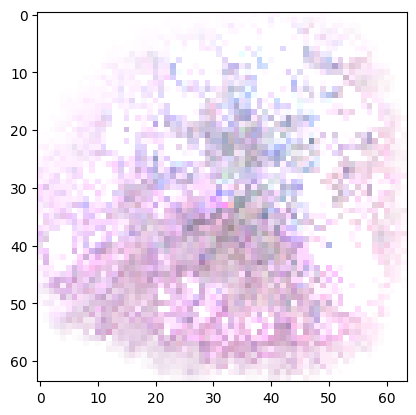

Epoch 52, Loss: 29.3768310546875
Epoch 53, Loss: 12.404801368713379
Epoch 54, Loss: 47.286376953125
Epoch 55, Loss: 57.863746643066406
Epoch 56, Loss: 27.755842208862305
Epoch 57, Loss: 20.72814178466797
Epoch 58, Loss: 17.669713973999023
Epoch 59, Loss: 18.06011390686035
Epoch 60, Loss: 42.197021484375
Epoch 61, Loss: 75.88619232177734
Epoch 62, Loss: 30.35213279724121
Epoch 63, Loss: 27.329498291015625
Epoch 64, Loss: 14.572298049926758
Epoch 65, Loss: 29.331558227539062
Epoch 66, Loss: 37.432823181152344
Epoch 67, Loss: 46.400184631347656
Epoch 68, Loss: 28.64931297302246
Epoch 69, Loss: 32.420223236083984
Epoch 70, Loss: 15.559436798095703
Epoch 71, Loss: 21.824874877929688
Epoch 72, Loss: 29.27391815185547
Epoch 73, Loss: 63.7148323059082
Epoch 74, Loss: 29.03066635131836
Epoch 75, Loss: 9.459821701049805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 76, Loss: 29.745656967163086


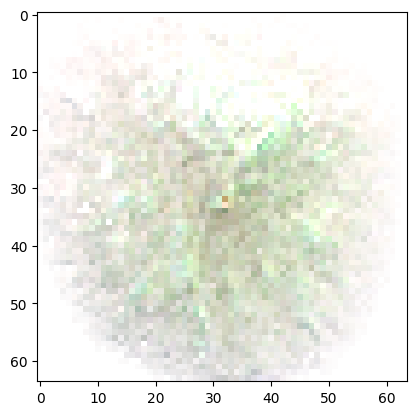

Epoch 77, Loss: 9.877578735351562
Epoch 78, Loss: 8.386940002441406
Epoch 79, Loss: 11.380693435668945
Epoch 80, Loss: 15.775078773498535
Epoch 81, Loss: 36.10403823852539
Epoch 82, Loss: 20.017520904541016
Epoch 83, Loss: 7.508418083190918
Epoch 84, Loss: 27.907747268676758
Epoch 85, Loss: 29.74947738647461
Epoch 86, Loss: 41.491966247558594
Epoch 87, Loss: 20.816137313842773
Epoch 88, Loss: 32.40143585205078
Epoch 89, Loss: 18.35849952697754
Epoch 90, Loss: 9.254911422729492
Epoch 91, Loss: 24.47346305847168
Epoch 92, Loss: 9.989609718322754
Epoch 93, Loss: 20.085180282592773
Epoch 94, Loss: 14.350255966186523
Epoch 95, Loss: 10.259871482849121
Epoch 96, Loss: 24.04590606689453
Epoch 97, Loss: 11.619779586791992
Epoch 98, Loss: 11.542903900146484
Epoch 99, Loss: 9.823622703552246
Epoch 100, Loss: 12.614555358886719


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 101, Loss: 15.478009223937988


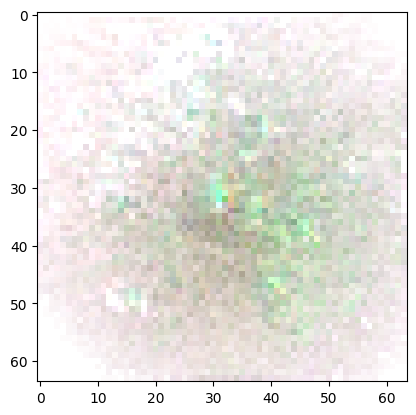

Epoch 102, Loss: 15.001365661621094
Epoch 103, Loss: 8.181951522827148
Epoch 104, Loss: 7.8523359298706055
Epoch 105, Loss: 39.716575622558594
Epoch 106, Loss: 48.0786018371582
Epoch 107, Loss: 8.912508010864258
Epoch 108, Loss: 8.402713775634766
Epoch 109, Loss: 6.766851425170898
Epoch 110, Loss: 6.0166120529174805
Epoch 111, Loss: 6.943148612976074
Epoch 112, Loss: 8.90375804901123
Epoch 113, Loss: 14.468942642211914
Epoch 114, Loss: 7.886860370635986
Epoch 115, Loss: 5.6202216148376465
Epoch 116, Loss: 7.132507801055908
Epoch 117, Loss: 13.110846519470215
Epoch 118, Loss: 4.863887310028076
Epoch 119, Loss: 6.76248836517334
Epoch 120, Loss: 6.890316486358643
Epoch 121, Loss: 5.4126667976379395
Epoch 122, Loss: 8.573002815246582
Epoch 123, Loss: 7.747498035430908
Epoch 124, Loss: 7.50550651550293
Epoch 125, Loss: 6.446156024932861


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 126, Loss: 9.12439250946045


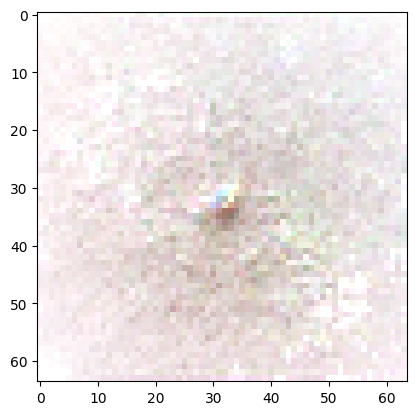

Epoch 127, Loss: 5.267185211181641
Epoch 128, Loss: 5.30759334564209
Epoch 129, Loss: 4.009249687194824
Epoch 130, Loss: 9.439555168151855
Epoch 131, Loss: 5.068752765655518
Epoch 132, Loss: 7.086019039154053
Epoch 133, Loss: 4.654825687408447
Epoch 134, Loss: 3.8859143257141113
Epoch 135, Loss: 4.75687837600708
Epoch 136, Loss: 4.823331356048584
Epoch 137, Loss: 4.27004861831665
Epoch 138, Loss: 3.6845405101776123
Epoch 139, Loss: 3.8953657150268555
Epoch 140, Loss: 4.2981953620910645
Epoch 141, Loss: 3.4202375411987305
Epoch 142, Loss: 3.504364252090454
Epoch 143, Loss: 3.373721122741699
Epoch 144, Loss: 3.877501964569092
Epoch 145, Loss: 6.793071269989014
Epoch 146, Loss: 7.027794361114502
Epoch 147, Loss: 5.558908939361572
Epoch 148, Loss: 3.784559965133667
Epoch 149, Loss: 4.1937971115112305
Epoch 150, Loss: 3.9391233921051025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 151, Loss: 3.2549076080322266


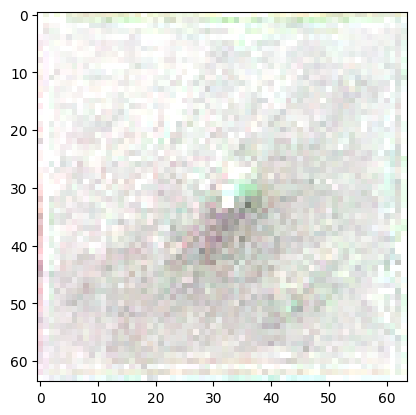

Epoch 152, Loss: 4.445621490478516
Epoch 153, Loss: 3.514004945755005
Epoch 154, Loss: 4.00045108795166
Epoch 155, Loss: 3.3044257164001465
Epoch 156, Loss: 3.7182934284210205
Epoch 157, Loss: 3.3730924129486084
Epoch 158, Loss: 3.6093502044677734
Epoch 159, Loss: 4.1348090171813965
Epoch 160, Loss: 3.738922357559204
Epoch 161, Loss: 3.341787338256836
Epoch 162, Loss: 3.113682508468628
Epoch 163, Loss: 3.023094654083252
Epoch 164, Loss: 6.726016044616699
Epoch 165, Loss: 2.85734224319458
Epoch 166, Loss: 2.5297346115112305
Epoch 167, Loss: 2.8465304374694824
Epoch 168, Loss: 2.464937448501587
Epoch 169, Loss: 2.3912465572357178
Epoch 170, Loss: 4.70822811126709
Epoch 171, Loss: 3.29727840423584
Epoch 172, Loss: 14.754369735717773
Epoch 173, Loss: 4.748133659362793
Epoch 174, Loss: 4.124739170074463
Epoch 175, Loss: 3.6621224880218506


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 176, Loss: 3.309056282043457


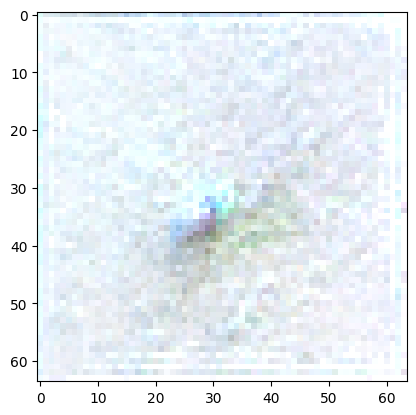

Epoch 177, Loss: 5.455756664276123
Epoch 178, Loss: 7.7347540855407715
Epoch 179, Loss: 4.5772528648376465
Epoch 180, Loss: 3.194084644317627
Epoch 181, Loss: 3.3105313777923584
Epoch 182, Loss: 3.4237570762634277
Epoch 183, Loss: 3.293872594833374
Epoch 184, Loss: 2.906311273574829
Epoch 185, Loss: 3.1356892585754395
Epoch 186, Loss: 6.321492671966553
Epoch 187, Loss: 3.6476147174835205
Epoch 188, Loss: 2.7726616859436035
Epoch 189, Loss: 2.971155881881714
Epoch 190, Loss: 2.8160035610198975
Epoch 191, Loss: 3.254544258117676
Epoch 192, Loss: 5.58907413482666
Epoch 193, Loss: 3.5064756870269775
Epoch 194, Loss: 4.375458717346191
Epoch 195, Loss: 3.4182872772216797
Epoch 196, Loss: 3.4445340633392334
Epoch 197, Loss: 4.0968017578125
Epoch 198, Loss: 3.153012275695801
Epoch 199, Loss: 2.7965877056121826
Epoch 200, Loss: 3.2932467460632324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 201, Loss: 2.748584032058716


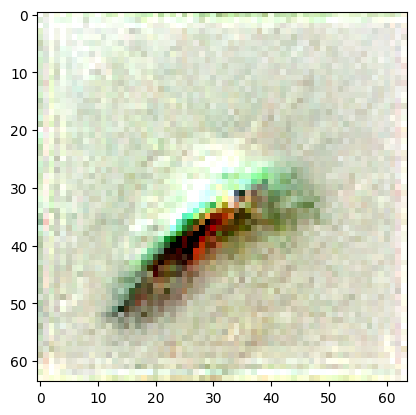

Epoch 202, Loss: 2.554567813873291
Epoch 203, Loss: 2.2320573329925537
Epoch 204, Loss: 2.4220242500305176
Epoch 205, Loss: 3.9453372955322266
Epoch 206, Loss: 3.820651054382324
Epoch 207, Loss: 5.657933712005615
Epoch 208, Loss: 12.667855262756348
Epoch 209, Loss: 4.198021411895752
Epoch 210, Loss: 3.5392544269561768
Epoch 211, Loss: 3.080131769180298
Epoch 212, Loss: 3.0654499530792236
Epoch 213, Loss: 3.1930789947509766
Epoch 214, Loss: 3.2355260848999023
Epoch 215, Loss: 2.703450918197632
Epoch 216, Loss: 4.19370698928833
Epoch 217, Loss: 3.609649181365967
Epoch 218, Loss: 3.3123693466186523
Epoch 219, Loss: 3.57551646232605
Epoch 220, Loss: 4.013774394989014
Epoch 221, Loss: 2.920804977416992
Epoch 222, Loss: 2.803898334503174
Epoch 223, Loss: 2.401493787765503
Epoch 224, Loss: 2.6591434478759766
Epoch 225, Loss: 3.1393866539001465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 226, Loss: 3.236633539199829


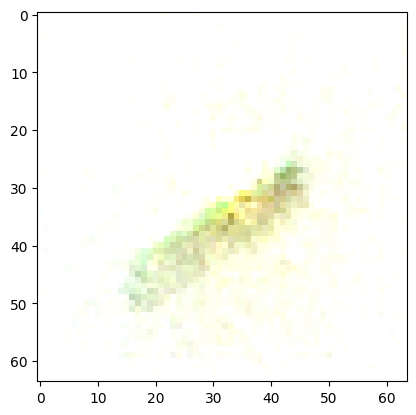

Epoch 227, Loss: 2.4394867420196533
Epoch 228, Loss: 2.0109317302703857
Epoch 229, Loss: 2.21612286567688
Epoch 230, Loss: 2.2899258136749268
Epoch 231, Loss: 2.235833168029785
Epoch 232, Loss: 1.996556282043457
Epoch 233, Loss: 1.8880798816680908
Epoch 234, Loss: 2.564863920211792
Epoch 235, Loss: 1.7553802728652954
Epoch 236, Loss: 3.540949821472168
Epoch 237, Loss: 2.1065399646759033
Epoch 238, Loss: 2.6020991802215576
Epoch 239, Loss: 1.988115906715393
Epoch 240, Loss: 4.226312637329102
Epoch 241, Loss: 2.071699619293213
Epoch 242, Loss: 2.4025824069976807
Epoch 243, Loss: 1.943086862564087
Epoch 244, Loss: 2.254803419113159
Epoch 245, Loss: 2.080411434173584
Epoch 246, Loss: 2.502018928527832
Epoch 247, Loss: 2.3540802001953125
Epoch 248, Loss: 2.0824685096740723
Epoch 249, Loss: 3.105161190032959
Epoch 250, Loss: 5.852355003356934


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 251, Loss: 2.974611282348633


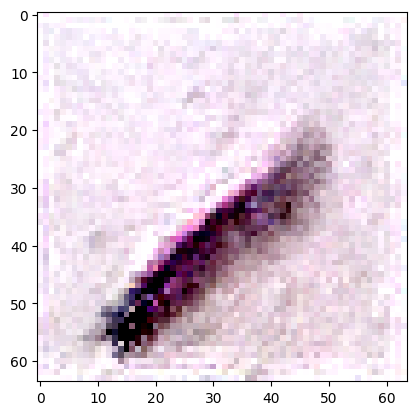

Epoch 252, Loss: 2.3597300052642822
Epoch 253, Loss: 2.0287458896636963
Epoch 254, Loss: 1.9166287183761597
Epoch 255, Loss: 2.1396803855895996
Epoch 256, Loss: 2.3397364616394043
Epoch 257, Loss: 3.1424527168273926
Epoch 258, Loss: 1.836833119392395
Epoch 259, Loss: 1.6236361265182495
Epoch 260, Loss: 2.283747434616089
Epoch 261, Loss: 2.6820805072784424
Epoch 262, Loss: 2.1617603302001953
Epoch 263, Loss: 2.154742956161499
Epoch 264, Loss: 1.9426779747009277
Epoch 265, Loss: 2.046304941177368
Epoch 266, Loss: 2.281017780303955
Epoch 267, Loss: 1.8285808563232422
Epoch 268, Loss: 1.7086796760559082
Epoch 269, Loss: 1.6518645286560059
Epoch 270, Loss: 1.9991427659988403
Epoch 271, Loss: 2.293144464492798
Epoch 272, Loss: 2.4213216304779053
Epoch 273, Loss: 1.8896065950393677
Epoch 274, Loss: 2.2919623851776123
Epoch 275, Loss: 2.035426378250122


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 276, Loss: 2.1199967861175537


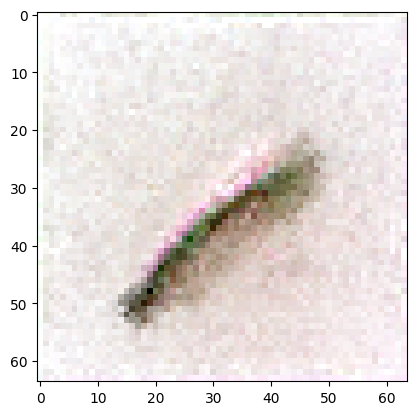

Epoch 277, Loss: 1.4723005294799805
Epoch 278, Loss: 1.7253469228744507
Epoch 279, Loss: 1.6764332056045532
Epoch 280, Loss: 2.064484119415283
Epoch 281, Loss: 2.123055934906006
Epoch 282, Loss: 2.059387683868408
Epoch 283, Loss: 2.0530343055725098
Epoch 284, Loss: 5.748800754547119
Epoch 285, Loss: 3.1063644886016846
Epoch 286, Loss: 2.541260004043579
Epoch 287, Loss: 2.147432327270508
Epoch 288, Loss: 2.2680840492248535
Epoch 289, Loss: 2.567600965499878
Epoch 290, Loss: 2.9490761756896973
Epoch 291, Loss: 2.103846311569214
Epoch 292, Loss: 1.9552578926086426
Epoch 293, Loss: 1.9570339918136597
Epoch 294, Loss: 2.2974119186401367
Epoch 295, Loss: 1.8869571685791016
Epoch 296, Loss: 1.861204981803894
Epoch 297, Loss: 1.7088876962661743
Epoch 298, Loss: 1.6228212118148804
Epoch 299, Loss: 1.6771750450134277
Epoch 300, Loss: 1.7692461013793945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 301, Loss: 1.4209026098251343


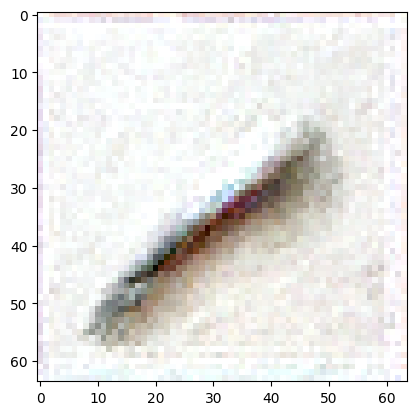

Epoch 302, Loss: 1.4226489067077637
Epoch 303, Loss: 1.6118463277816772
Epoch 304, Loss: 1.702224612236023
Epoch 305, Loss: 2.1517980098724365
Epoch 306, Loss: 1.7793238162994385
Epoch 307, Loss: 1.635124683380127
Epoch 308, Loss: 1.7462693452835083
Epoch 309, Loss: 1.8043078184127808
Epoch 310, Loss: 1.5276106595993042
Epoch 311, Loss: 1.4288777112960815
Epoch 312, Loss: 1.7689532041549683
Epoch 313, Loss: 1.574925184249878
Epoch 314, Loss: 1.963226318359375
Epoch 315, Loss: 1.7764441967010498
Epoch 316, Loss: 1.7375675439834595
Epoch 317, Loss: 1.9350931644439697
Epoch 318, Loss: 1.4678219556808472
Epoch 319, Loss: 2.162761688232422
Epoch 320, Loss: 2.2521772384643555
Epoch 321, Loss: 1.4159690141677856
Epoch 322, Loss: 1.368338942527771
Epoch 323, Loss: 2.2123725414276123
Epoch 324, Loss: 1.365556240081787
Epoch 325, Loss: 1.7331924438476562


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 326, Loss: 1.392687201499939


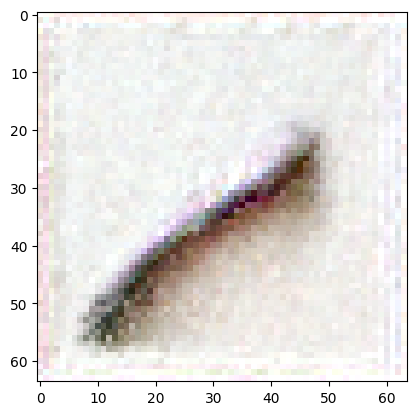

Epoch 327, Loss: 1.579071044921875
Epoch 328, Loss: 1.4422392845153809
Epoch 329, Loss: 1.3208050727844238
Epoch 330, Loss: 1.5102455615997314
Epoch 331, Loss: 1.3703194856643677
Epoch 332, Loss: 1.294797658920288
Epoch 333, Loss: 1.234177827835083
Epoch 334, Loss: 1.446609616279602
Epoch 335, Loss: 1.5768342018127441
Epoch 336, Loss: 1.6472206115722656
Epoch 337, Loss: 1.2476458549499512
Epoch 338, Loss: 1.3707330226898193
Epoch 339, Loss: 1.3269000053405762
Epoch 340, Loss: 1.3248722553253174
Epoch 341, Loss: 1.525180459022522
Epoch 342, Loss: 1.372066855430603
Epoch 343, Loss: 1.643212914466858
Epoch 344, Loss: 1.332891821861267
Epoch 345, Loss: 1.4158744812011719
Epoch 346, Loss: 1.6174936294555664
Epoch 347, Loss: 1.5304498672485352
Epoch 348, Loss: 3.2609801292419434
Epoch 349, Loss: 1.9992647171020508
Epoch 350, Loss: 1.341563105583191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 351, Loss: 1.4915680885314941


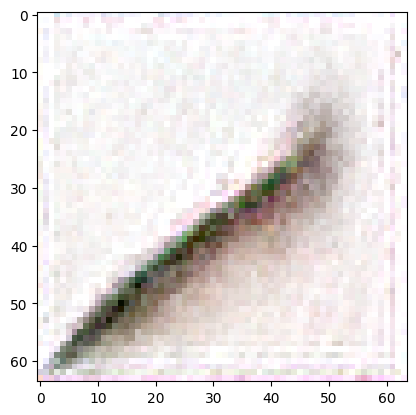

Epoch 352, Loss: 1.8311079740524292
Epoch 353, Loss: 2.0102999210357666
Epoch 354, Loss: 1.7278211116790771
Epoch 355, Loss: 2.3636844158172607
Epoch 356, Loss: 1.8930509090423584
Epoch 357, Loss: 1.7110141515731812
Epoch 358, Loss: 1.5292994976043701
Epoch 359, Loss: 1.5125242471694946
Epoch 360, Loss: 1.6201019287109375
Epoch 361, Loss: 1.43351149559021
Epoch 362, Loss: 1.3690022230148315
Epoch 363, Loss: 1.2589792013168335
Epoch 364, Loss: 1.2448748350143433
Epoch 365, Loss: 1.2123236656188965
Epoch 366, Loss: 1.5743401050567627
Epoch 367, Loss: 1.34306001663208
Epoch 368, Loss: 1.3405159711837769
Epoch 369, Loss: 1.3617507219314575
Epoch 370, Loss: 1.635317087173462
Epoch 371, Loss: 1.4327611923217773
Epoch 372, Loss: 1.522362470626831
Epoch 373, Loss: 1.2668895721435547
Epoch 374, Loss: 1.1835782527923584
Epoch 375, Loss: 1.3633793592453003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 376, Loss: 1.257662296295166


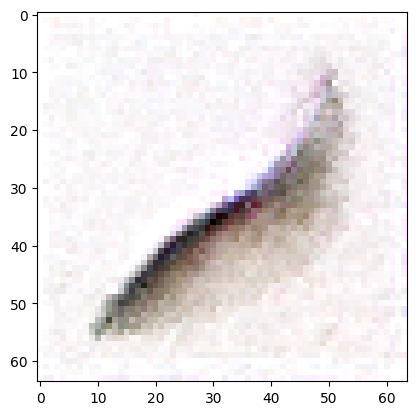

Epoch 377, Loss: 1.616532325744629
Epoch 378, Loss: 1.766784429550171
Epoch 379, Loss: 1.4014333486557007
Epoch 380, Loss: 1.3540443181991577
Epoch 381, Loss: 1.2876936197280884
Epoch 382, Loss: 1.2110499143600464
Epoch 383, Loss: 1.2984058856964111
Epoch 384, Loss: 1.2957212924957275
Epoch 385, Loss: 1.2668347358703613
Epoch 386, Loss: 1.218653678894043
Epoch 387, Loss: 1.2056118249893188
Epoch 388, Loss: 1.1071562767028809
Epoch 389, Loss: 1.2024140357971191
Epoch 390, Loss: 1.5498310327529907
Epoch 391, Loss: 1.1633083820343018
Epoch 392, Loss: 1.2180793285369873
Epoch 393, Loss: 1.1299092769622803
Epoch 394, Loss: 1.9071661233901978
Epoch 395, Loss: 1.3700952529907227
Epoch 396, Loss: 1.1284083127975464
Epoch 397, Loss: 1.396802544593811
Epoch 398, Loss: 1.1185808181762695
Epoch 399, Loss: 1.1187986135482788
Epoch 400, Loss: 1.2486519813537598


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 401, Loss: 1.3476855754852295


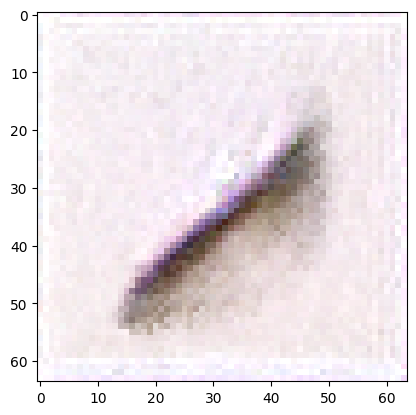

Epoch 402, Loss: 1.425685167312622
Epoch 403, Loss: 1.2652980089187622
Epoch 404, Loss: 1.4308805465698242
Epoch 405, Loss: 1.1693480014801025
Epoch 406, Loss: 1.354304552078247
Epoch 407, Loss: 1.2623608112335205
Epoch 408, Loss: 1.228250503540039
Epoch 409, Loss: 1.3244447708129883
Epoch 410, Loss: 1.1875495910644531
Epoch 411, Loss: 1.2777743339538574
Epoch 412, Loss: 1.1419273614883423
Epoch 413, Loss: 1.2068333625793457
Epoch 414, Loss: 1.4188568592071533
Epoch 415, Loss: 1.4071074724197388
Epoch 416, Loss: 1.5454601049423218
Epoch 417, Loss: 1.3157888650894165
Epoch 418, Loss: 1.9090211391448975
Epoch 419, Loss: 1.4219071865081787
Epoch 420, Loss: 1.4526190757751465
Epoch 421, Loss: 1.2316539287567139
Epoch 422, Loss: 1.0628095865249634
Epoch 423, Loss: 1.3544278144836426
Epoch 424, Loss: 1.2749764919281006
Epoch 425, Loss: 1.2611663341522217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 426, Loss: 1.3747860193252563


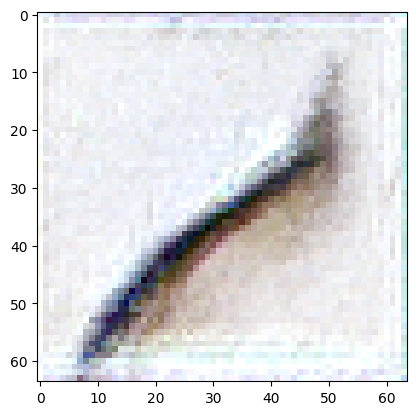

Epoch 427, Loss: 1.4481351375579834
Epoch 428, Loss: 1.1392958164215088
Epoch 429, Loss: 1.1685525178909302
Epoch 430, Loss: 1.281023621559143
Epoch 431, Loss: 1.6487168073654175
Epoch 432, Loss: 1.2447397708892822
Epoch 433, Loss: 1.2578321695327759
Epoch 434, Loss: 1.089310646057129
Epoch 435, Loss: 1.3030645847320557
Epoch 436, Loss: 1.2586092948913574
Epoch 437, Loss: 1.1605372428894043
Epoch 438, Loss: 1.7406048774719238
Epoch 439, Loss: 1.5492194890975952
Epoch 440, Loss: 1.4735965728759766
Epoch 441, Loss: 1.5471396446228027
Epoch 442, Loss: 1.385391354560852
Epoch 443, Loss: 1.3998465538024902
Epoch 444, Loss: 1.0900911092758179
Epoch 445, Loss: 1.2394620180130005
Epoch 446, Loss: 1.0930404663085938
Epoch 447, Loss: 1.166178584098816
Epoch 448, Loss: 1.3272027969360352
Epoch 449, Loss: 1.4580093622207642
Epoch 450, Loss: 1.3340078592300415


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 451, Loss: 1.1361862421035767


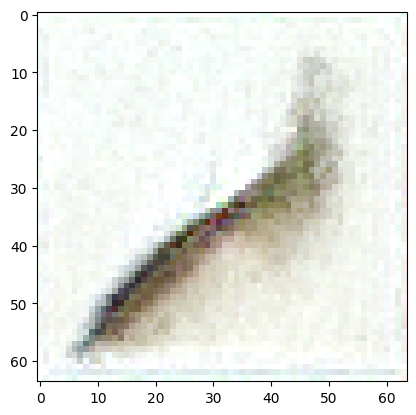

Epoch 452, Loss: 1.3233002424240112
Epoch 453, Loss: 1.0128939151763916
Epoch 454, Loss: 0.9856742024421692
Epoch 455, Loss: 1.0743305683135986
Epoch 456, Loss: 1.316705346107483
Epoch 457, Loss: 1.2851976156234741
Epoch 458, Loss: 1.0276414155960083
Epoch 459, Loss: 1.0732799768447876
Epoch 460, Loss: 1.5409787893295288
Epoch 461, Loss: 1.1391056776046753
Epoch 462, Loss: 1.0627597570419312
Epoch 463, Loss: 1.828895092010498
Epoch 464, Loss: 1.0304638147354126
Epoch 465, Loss: 1.0782899856567383
Epoch 466, Loss: 1.1575934886932373
Epoch 467, Loss: 1.1101391315460205
Epoch 468, Loss: 1.0606187582015991
Epoch 469, Loss: 0.9140862822532654
Epoch 470, Loss: 0.981876790523529
Epoch 471, Loss: 1.1493034362792969
Epoch 472, Loss: 1.2920875549316406
Epoch 473, Loss: 1.1533032655715942
Epoch 474, Loss: 1.1283341646194458
Epoch 475, Loss: 1.0793689489364624


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 476, Loss: 1.0995235443115234


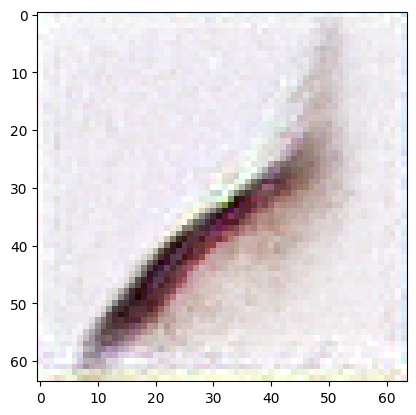

Epoch 477, Loss: 1.3430581092834473
Epoch 478, Loss: 0.9441667199134827
Epoch 479, Loss: 1.0416892766952515
Epoch 480, Loss: 0.9869040846824646
Epoch 481, Loss: 1.167298674583435
Epoch 482, Loss: 1.075897455215454
Epoch 483, Loss: 0.9836723804473877
Epoch 484, Loss: 0.9055559635162354
Epoch 485, Loss: 1.2659687995910645
Epoch 486, Loss: 1.269202709197998
Epoch 487, Loss: 0.9466578364372253
Epoch 488, Loss: 1.4618816375732422
Epoch 489, Loss: 1.053249716758728
Epoch 490, Loss: 1.2158324718475342
Epoch 491, Loss: 1.2833476066589355
Epoch 492, Loss: 1.7334215641021729
Epoch 493, Loss: 1.8851581811904907
Epoch 494, Loss: 1.2478195428848267
Epoch 495, Loss: 1.6221750974655151
Epoch 496, Loss: 1.5151311159133911
Epoch 497, Loss: 1.2363911867141724
Epoch 498, Loss: 1.2099394798278809
Epoch 499, Loss: 1.3657512664794922
Epoch 500, Loss: 1.2436234951019287


In [13]:
EPOCHS = 500
for epoch in range(EPOCHS):
    x, loss = train_step(x0)
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch + 1, loss))

    if epoch % 25 == 0:
        plot(x)

In [14]:
model.save("testModel")

INFO:tensorflow:Assets written to: testModel/assets


INFO:tensorflow:Assets written to: testModel/assets


In [15]:
#@title TensorFlow.js Demo {run:"auto", vertical-output: true}
#@markdown Select "CHECKPOINT" model to load the checkpoint created by running cells from the "Training" section of this notebook
import IPython.display

data_js = '''
  window.GRAPH_URL = URL.createObjectURL(new Blob([`%s`], {type: 'application/json'}));
'''%(model)

display(IPython.display.Javascript(data_js))

IPython.display.HTML('''
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@2.3.0/dist/tf.min.js"></script>

<canvas id='canvas' style="border: 1px solid black; image-rendering: pixelated;"></canvas>

<script>
  "use strict";
  
  const sleep = (ms)=>new Promise(resolve => setTimeout(resolve, ms));

  const parseConsts = model_graph=>{
    const dtypes = {'DT_INT32':['int32', 'intVal', Int32Array],
                    'DT_FLOAT':['float32', 'floatVal', Float32Array]};
    
    const consts = {};
    model_graph.modelTopology.node.filter(n=>n.op=='Const').forEach((node=>{
      const v = node.attr.value.tensor;
      const [dtype, field, arrayType] = dtypes[v.dtype];
      if (!v.tensorShape.dim) {
        consts[node.name] = [tf.scalar(v[field][0], dtype)];
      } else {
        // if there is a 0-length dimension, the exported graph json lacks "size"
        const shape = v.tensorShape.dim.map(d=>(!d.size) ? 0 : parseInt(d.size));
        let arr;
        if (v.tensorContent) {
          const data = atob(v.tensorContent);
          const buf = new Uint8Array(data.length);
          for (var i=0; i<data.length; ++i) {
            buf[i] = data.charCodeAt(i);
          }
          arr = new arrayType(buf.buffer);
        } else {
          const size = shape.reduce((a, b)=>a*b);
          arr = new arrayType(size);
          if (size) {
            arr.fill(v[field][0]);
          }
        }
        consts[node.name] = [tf.tensor(arr, shape, dtype)];
      }
    }));
    return consts;
  }
  
  const run = async ()=>{
    const r = await fetch(GRAPH_URL);
    const consts = parseConsts(await r.json());
    
    const model = await tf.loadGraphModel(GRAPH_URL);
    Object.assign(model.weights, consts);
    
    let seed = new Array(16).fill(0).map((x, i)=>i<3?0:1);
    seed = tf.tensor(seed, [1, 1, 1, 16]);
    
    const D = 96;
    const initState = tf.tidy(()=>{
      const D2 = D/2;
      const a = seed.pad([[0, 0], [D2-1, D2], [D2-1, D2], [0,0]]);
      return a;
    });
    
    const state = tf.variable(initState);
    const [_, h, w, ch] = state.shape;
    
    const damage = (x, y, r)=>{
      tf.tidy(()=>{
        const rx = tf.range(0, w).sub(x).div(r).square().expandDims(0);
        const ry = tf.range(0, h).sub(y).div(r).square().expandDims(1);
        const mask = rx.add(ry).greater(1.0).expandDims(2);
        state.assign(state.mul(mask));
      });
    }
    
    const plantSeed = (x, y)=>{
      const x2 = w-x-seed.shape[2];
      const y2 = h-y-seed.shape[1];
      if (x<0 || x2<0 || y2<0 || y2<0)
        return;
      tf.tidy(()=>{
        const a = seed.pad([[0, 0], [y, y2], [x, x2], [0,0]]);
        state.assign(state.add(a));
      });
    }
    
    const scale = 4;
    
    const canvas = document.getElementById('canvas');
    const ctx = canvas.getContext('2d');
    canvas.width = w;
    canvas.height = h;
    canvas.style.width = `${w*scale}px`;
    canvas.style.height = `${h*scale}px`;
    
    canvas.onmousedown = e=>{
      const x = Math.floor(e.clientX/scale);
        const y = Math.floor(e.clientY/scale);
        if (e.buttons == 1) {
          if (e.shiftKey) {
            plantSeed(x, y);  
          } else {
            damage(x, y, 8);
          }
        }
    }
    canvas.onmousemove = e=>{
      const x = Math.floor(e.clientX/scale);
      const y = Math.floor(e.clientY/scale);
      if (e.buttons == 1 && !e.shiftKey) {
        damage(x, y, 8);
      }
    }

    function step() {
      tf.tidy(()=>{
        state.assign(model.execute(
            {x:state, fire_rate:tf.tensor(0.5),
            angle:tf.tensor(0.0), step_size:tf.tensor(1.0)}, ['Identity']));
      });
    }

    function render() {
      step();

      const imageData = tf.tidy(()=>{
        const rgba = state.slice([0, 0, 0, 0], [-1, -1, -1, 4]);
        const a = state.slice([0, 0, 0, 3], [-1, -1, -1, 1]);
        const img = tf.tensor(1.0).sub(a).add(rgba).mul(255);
        const rgbaBytes = new Uint8ClampedArray(img.dataSync());
        return new ImageData(rgbaBytes, w, h);
      });
      ctx.putImageData(imageData, 0, 0);

      requestAnimationFrame(render);
    }
    render();
  }
  run();
  
</script>
''')

<IPython.core.display.Javascript object>